In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import torch
from attrdict import AttrDict
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import classifiers
from woe import WoEGaussian, WoEExplainer

# Constants
SELECTED_FEATURES = [
    "OverallQual",
    "Age",
    "Location",
    "KitchenQual_Ex",
    "Fireplaces",
    "CentralAirNum",
]

FEATURE_DISPLAY_NAMES = {
    "OverallQual": "Quality of \n Construction",
    "Age": "House Age",
    "KitchenQual_Ex": "Kitchen \n Quality",
    "CentralAirNum": "Central Air \n Conditioning",
}

PRICE_BINS = [(0, 130000), (150000, 190000), (210000, 1000000)]

PRICE_LABELS = ["low", "medium", "high"]


class AmesHousingDataset:
    def __init__(self, filepath="online_data/ames_engineered.csv", drop_duplicates=False):
        self.filepath = filepath
        self.drop_duplicates = drop_duplicates
        self.undersample = NearMiss(version=1)
        self.label_encoder = LabelEncoder()

    def load_data(self):
        """Load and preprocess the Ames Housing dataset."""
        # Load data
        df = pd.read_csv(self.filepath)
        df = df[~df["GarageArea"].isnull()]  # Remove single null value

        # Extract features and target
        X, Y = self._pre_processing(df)

        # Optional duplicate removal
        if self.drop_duplicates:
            X, Y = self._remove_duplicates(X, Y)

        # Balance dataset
        X, Y = self._balance_dataset(X, Y)

        # Split data
        return self._split_data(X, Y)

    def _pre_processing(self, df):
        X = df[SELECTED_FEATURES].copy()
        X = X.rename(columns=FEATURE_DISPLAY_NAMES)

        price_intervals = pd.IntervalIndex.from_tuples(PRICE_BINS)
        bins = pd.cut(df["SalePrice"], price_intervals)
        Y = self.label_encoder.fit_transform(bins)

        # Remove NaN price bins
        nan_idx = np.where(Y == 3)[0]
        Y = np.delete(Y, nan_idx)
        X = X.drop(X.index[nan_idx])
        X = X.reset_index(drop=True)
        return X, Y

    def _remove_duplicates(self, X, Y):
        """Remove duplicate feature rows while maintaining corresponding labels."""
        UX = X.drop_duplicates()
        idx_UX = list(UX.index.values)
        UY = [Y[i] for i in idx_UX]
        return UX, UY

    def _balance_dataset(self, X, Y):
        """Balance the dataset using NearMiss undersampling."""
        if isinstance(X, pd.DataFrame):
            X_resampled, Y_resampled = self.undersample.fit_resample(X.to_numpy(), Y)
            X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        else:
            X_resampled, Y_resampled = self.undersample.fit_resample(X, Y)
        return X_resampled, Y_resampled

    def _split_data(self, X, Y):
        """Split data into train and test sets and create AttrDict objects."""
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.2, random_state=8
        )

        X_dict = AttrDict(
            {
                "train": X_train,
                "test": X_test,
                "features": (
                    X.columns if isinstance(X, pd.DataFrame) else SELECTED_FEATURES
                ),
            }
        )

        Y_dict = AttrDict({"train": Y_train, "test": Y_test, "classes": PRICE_LABELS})

        feature_groups = AttrDict({"names": None, "idxs": None})

        return X_dict, Y_dict, feature_groups


class TabularWoeProcessing:
    def __init__(self, X, Y, feature_groups):
        self.X = X
        self.Y = Y
        self.feature_groups = feature_groups
        self.classifier = None
        self.woe_model = None
        self.woe_explainer = None

    def train(self):
        """Train the classifier and create WoE models."""
        # Train classifier
        self.classifier = classifiers.factory(model_type="gnb")
        self.classifier.fit(self.X.train.values, self.Y.train)

        # Create WoE model
        self.woe_model = WoEGaussian(
            classifier_model=self.classifier,
            X=self.X.train.values,
            y=self.Y.train,
            no_features=len(SELECTED_FEATURES),
            woe_clf="original",
            class_indices=list(range(len(self.Y.classes))),
        )

        # Create WoE explainer
        self.woe_explainer = WoEExplainer(
            woe_model=self.woe_model,
            classes=self.Y.classes,
            features=self.X.features,
            total_woe_correction=True,
            featgroup_idxs=self.feature_groups.idxs,
            featgroup_names=self.feature_groups.names,
        )

    def evaluate(self):
        """Evaluate the classifier performance."""
        train_accuracy = 100 * self.classifier.score(self.X.train, self.Y.train)
        test_accuracy = 100 * self.classifier.score(self.X.test, self.Y.test)

        print(f"Accuracy on train: {train_accuracy:4.2f}%")
        print(f"Accuracy on test: {test_accuracy:4.2f}%")

        return train_accuracy, test_accuracy


# Load and prepare data
dataset = AmesHousingDataset(drop_duplicates=False)
X, Y, feature_groups = dataset.load_data()

# Train and evaluate classifier
classifier = TabularWoeProcessing(X, Y, feature_groups)
classifier.train()
classifier.evaluate()

Processing WOE Gaussian model...
Prediction: 0, torch.Size([512, 6]), 0.00s
Prediction: 1, torch.Size([503, 6]), 0.00s
Prediction: 2, torch.Size([521, 6]), 0.00s
Priors:  tensor([0.3333, 0.3275, 0.3392], dtype=torch.float64)
Means:  tensor([[4.8633e+00, 6.0785e+01, 1.6094e+00, 5.8594e-03, 2.1094e-01, 8.1250e-01],
        [6.0974e+00, 3.0926e+01, 2.2843e+00, 5.9642e-03, 6.6203e-01, 9.9205e-01],
        [7.4702e+00, 1.1785e+01, 3.2975e+00, 1.5739e-01, 9.6545e-01, 9.9616e-01]],
       dtype=torch.float64)
Covs:  tensor([[[ 8.4624e-01, -2.8494e+00,  2.0854e-02,  2.7596e-03,  9.5432e-02,
           1.0152e-01],
         [-2.8494e+00,  5.3603e+02,  9.2961e-01,  4.6271e-02,  2.3545e-03,
          -2.9523e+00],
         [ 2.0854e-02,  9.2961e-01,  3.2461e-01,  3.3635e-04,  1.0152e-02,
           1.6634e-02],
         [ 2.7596e-03,  4.6271e-02,  3.3635e-04,  5.8364e-03,  7.1857e-04,
          -8.5616e-04],
         [ 9.5432e-02,  2.3545e-03,  1.0152e-02,  7.1857e-04,  1.9417e-01,
           1.4

(74.67447916666666, 75.0)

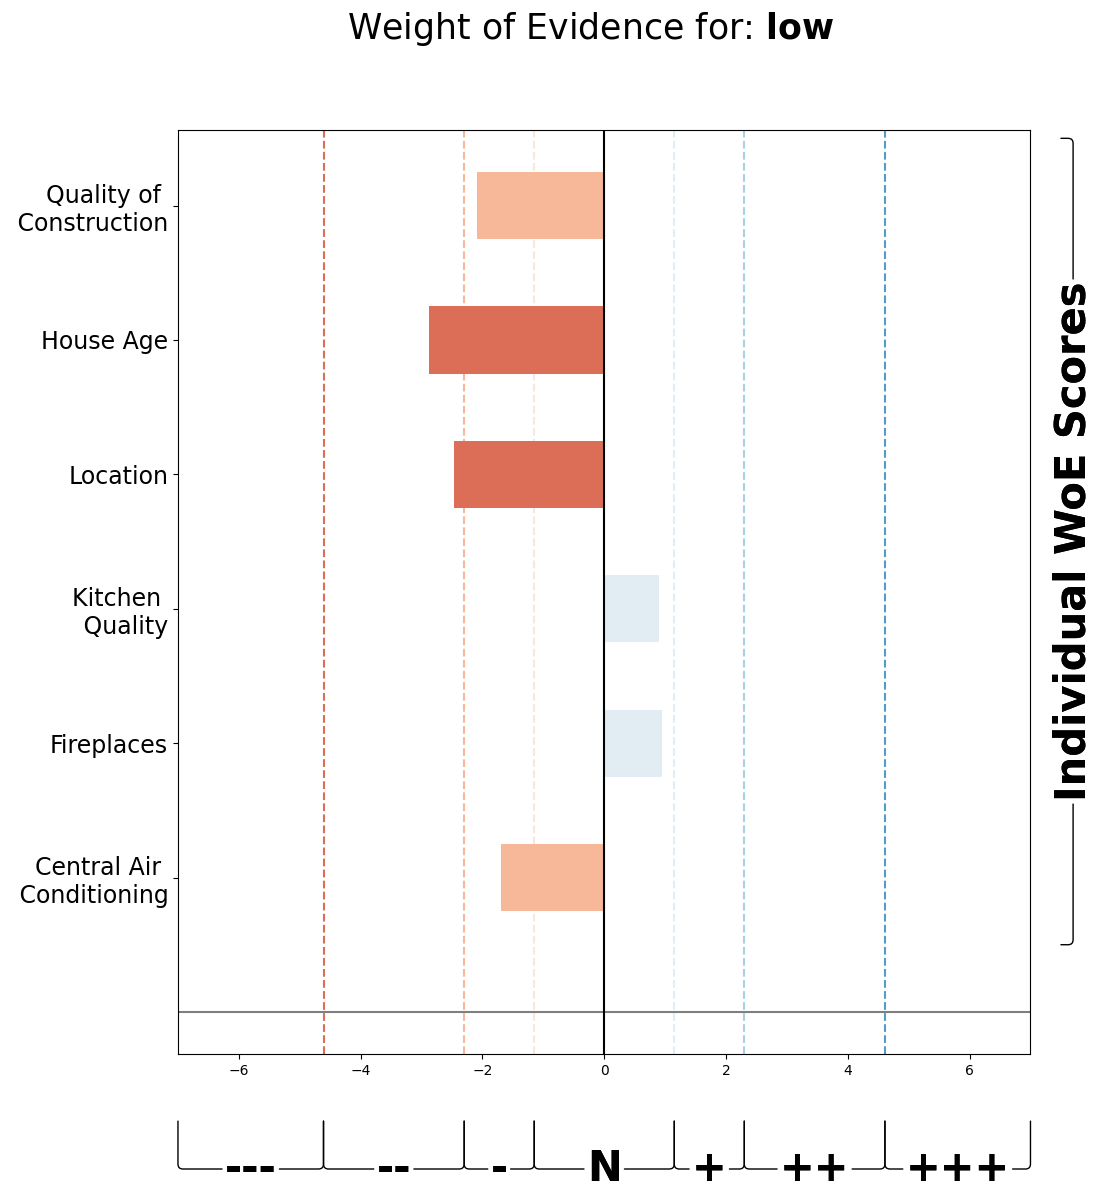

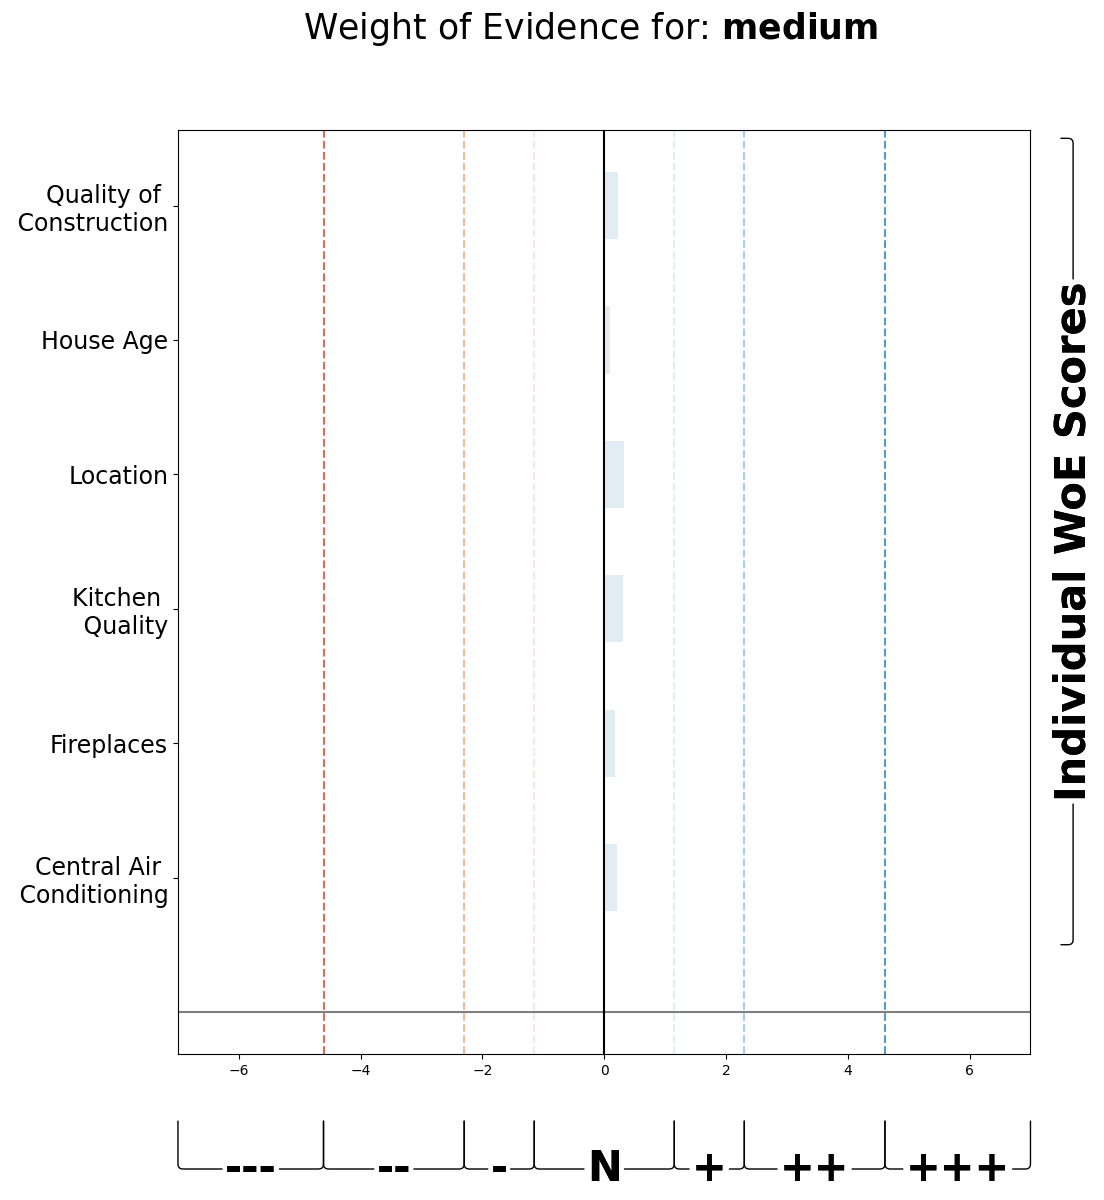

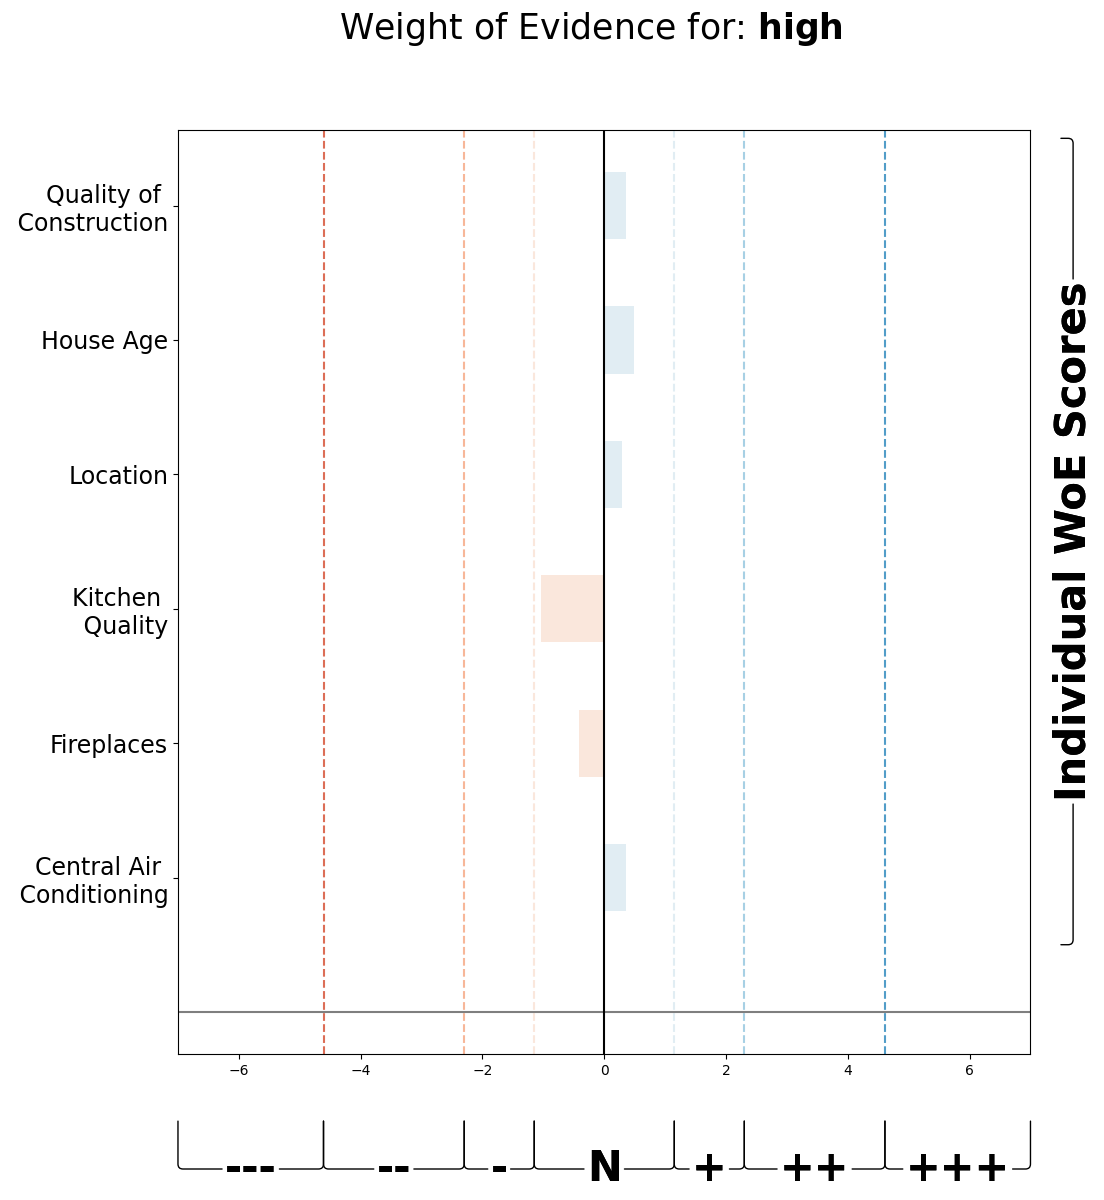

In [2]:
# Generate the evidence

x_test = torch.tensor(X.test.iloc[0].values, dtype=torch.float32)
for hypothesis_id, hypothesis_name in enumerate(Y.classes):
    explanation = classifier.woe_explainer.explain_for_human(
        x=x_test,
        hypothesis=hypothesis_id,
        units="features",
        plot=True,
        save_path=None,
        data_type="tabular",
        evidence_type="all",
        # save_path="example_evidence/tabular-{}.jpg".format(hypothesis_name),
    )